<a href="https://colab.research.google.com/github/pinilDissanayaka/COVID-19-Detection-from-Chest-X-rays/blob/main/code/Notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download pranavraikokte/covid19-image-dataset

100% 158M/158M [00:04<00:00, 39.8MB/s]
100% 158M/158M [00:04<00:00, 35.8MB/s]


In [3]:
! unzip /content/covid19-image-dataset.zip

Archive:  /content/covid19-image-dataset.zip
  inflating: Covid19-dataset/test/Covid/0100.jpeg  
  inflating: Covid19-dataset/test/Covid/0102.jpeg  
  inflating: Covid19-dataset/test/Covid/0105.png  
  inflating: Covid19-dataset/test/Covid/0106.jpeg  
  inflating: Covid19-dataset/test/Covid/0108.jpeg  
  inflating: Covid19-dataset/test/Covid/0111.jpg  
  inflating: Covid19-dataset/test/Covid/0112.jpg  
  inflating: Covid19-dataset/test/Covid/0113.jpg  
  inflating: Covid19-dataset/test/Covid/0115.jpeg  
  inflating: Covid19-dataset/test/Covid/0118.jpeg  
  inflating: Covid19-dataset/test/Covid/0119.jpeg  
  inflating: Covid19-dataset/test/Covid/0120.jpg  
  inflating: Covid19-dataset/test/Covid/094.png  
  inflating: Covid19-dataset/test/Covid/096.png  
  inflating: Covid19-dataset/test/Covid/098.jpeg  
  inflating: Covid19-dataset/test/Covid/COVID-00003b.jpg  
  inflating: Covid19-dataset/test/Covid/COVID-00012.jpg  
  inflating: Covid19-dataset/test/Covid/COVID-00022.jpg  
  inflatin

In [4]:
!pip install livelossplot
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 11.1 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2 as cv
from glob import glob
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from livelossplot import PlotLossesKerasTF
import visualkeras

%matplotlib inline

import warnings
warnings.filterwarnings(action = 'ignore')

In [6]:
mainDir = '/content/Covid19-dataset'

In [7]:
mainDirList = os.listdir(mainDir)
mainDirList

['test', 'train']

In [8]:
trainDir = mainDir + '/' + mainDirList[1]
testDir = mainDir + '/' + mainDirList[0]


print(f"Training directory : {trainDir}")
print(f"Testing directory : {testDir}")

Training directory : /content/Covid19-dataset/train
Testing directory : /content/Covid19-dataset/test


In [9]:
outDir = '/content/output'

if not os.path.exists(outDir):
  os.mkdir(outDir)

figDir = outDir + "/fig"
if not os.path.exists(figDir):
  os.mkdir(figDir)

modelDir = outDir + "/model"
if not os.path.exists(modelDir):
  os.mkdir(modelDir)

In [10]:
trainLabels = os.listdir(trainDir)
testLabels = os.listdir(testDir)

print(f"Training labels : {trainLabels}")
print()
print(f"Testing labels : {testLabels}")

Training labels : ['Covid', 'Normal', 'Viral Pneumonia']

Testing labels : ['Covid', 'Normal', 'Viral Pneumonia']


In [11]:
def plotImgs(dir, labels, nrows, ncols):
  for label in labels:
    temp = dir + '/' + label
    temp = glob(temp + '/*')
    imgToPrint = np.random.choice(temp, size = nrows*ncols)
    plt.figure(figsize = (25, 25))
    for i in range(len(imgToPrint)):
      img = plt.imread(imgToPrint[i])
      plt.subplot(nrows, ncols, i + 1)
      plt.imshow(img, cmap = 'gray')
      plt.title(label)
      plt.grid('off')
      plt.axis('off')
    plt.savefig(figDir + f'/{label}')
  plt.show()

In [12]:
for label in trainLabels:
  temp = trainDir + '/' + label
  print(temp)

/content/Covid19-dataset/train/Covid
/content/Covid19-dataset/train/Normal
/content/Covid19-dataset/train/Viral Pneumonia


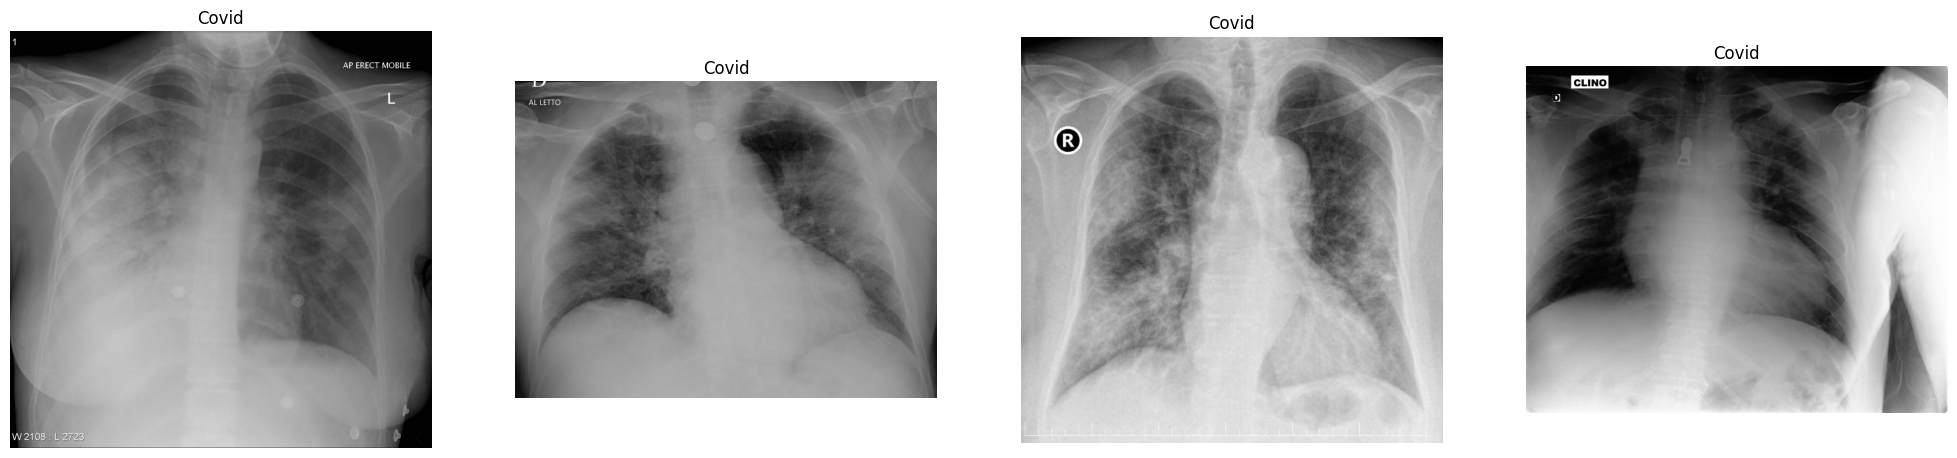

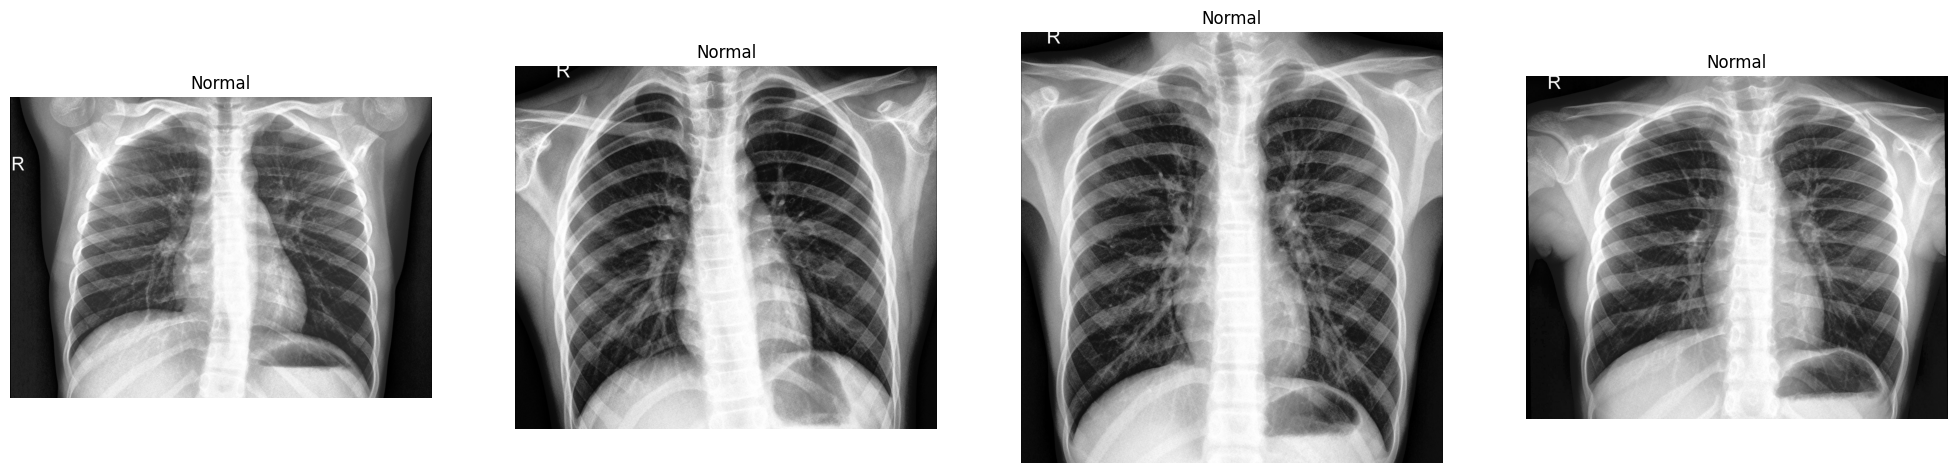

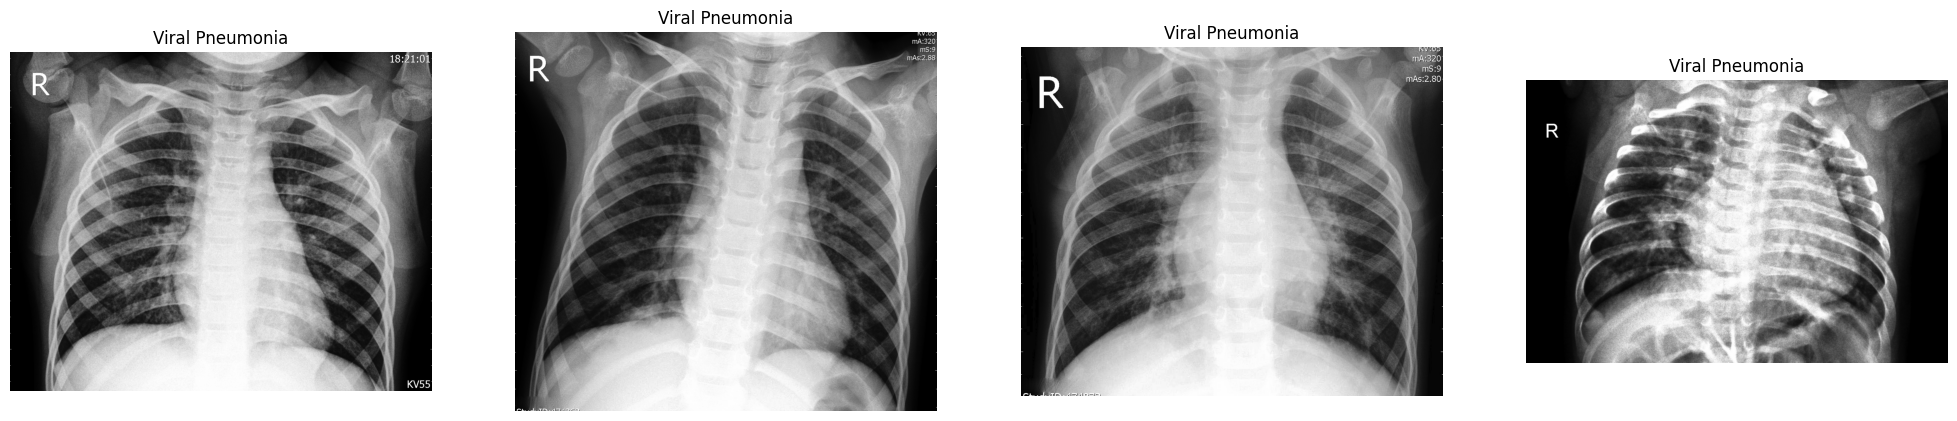

In [13]:
plotImgs(trainDir, trainLabels, 1, 4)

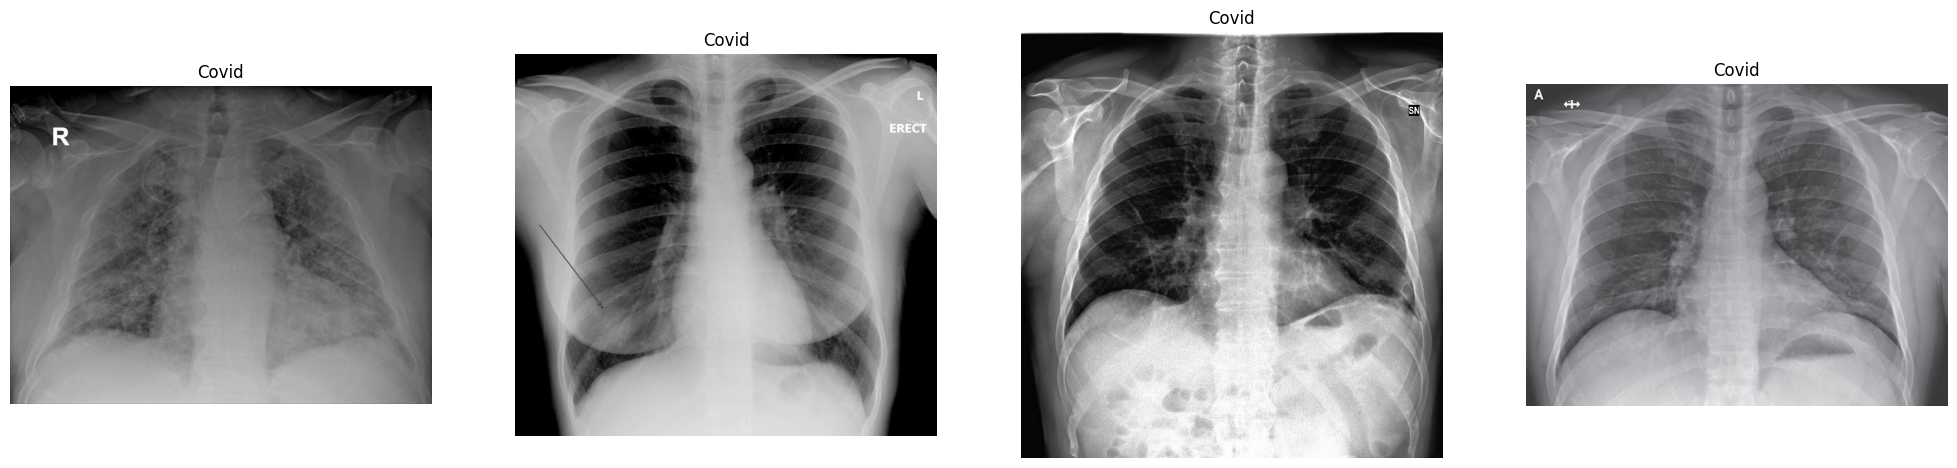

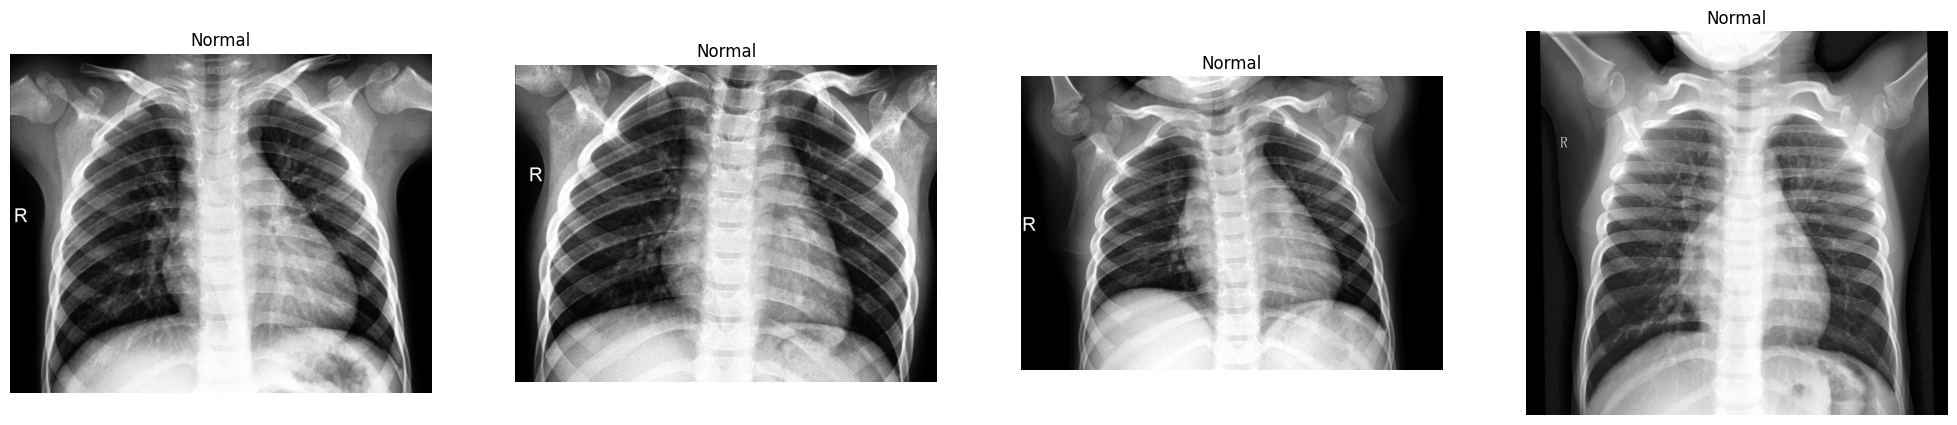

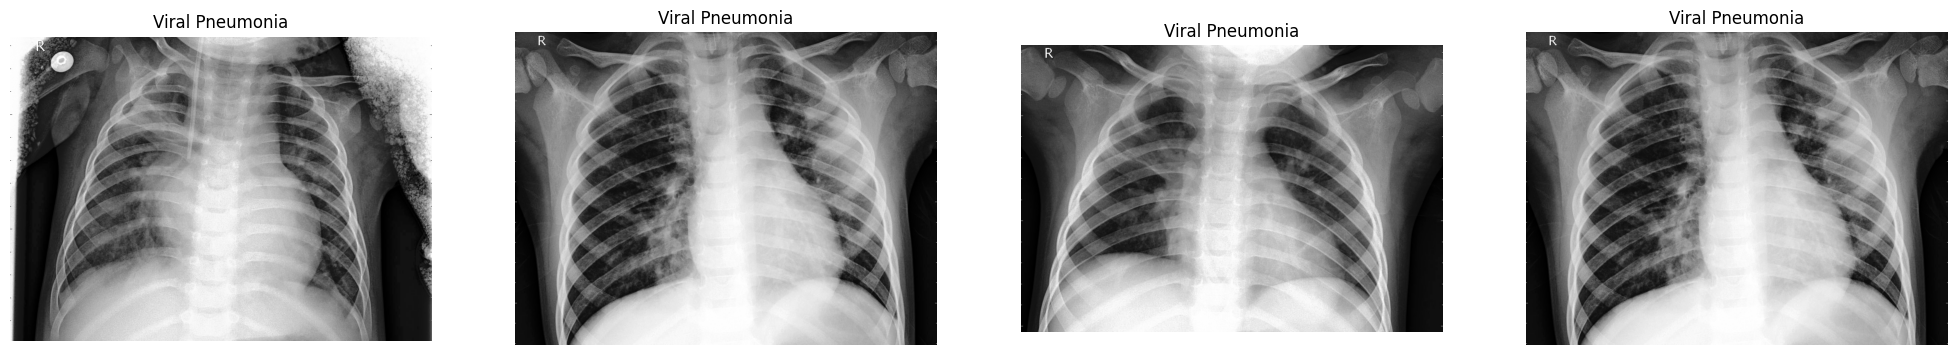

In [14]:
plotImgs(testDir, testLabels, 1, 4)

In [15]:
trainImgCount = {}
testImgCount = {}

def getImgCount(dir, labels, dic):
  for label in labels:
    temp = dir + '/' + label
    temp = glob(temp + '/*')
    dic[label] = len(temp)

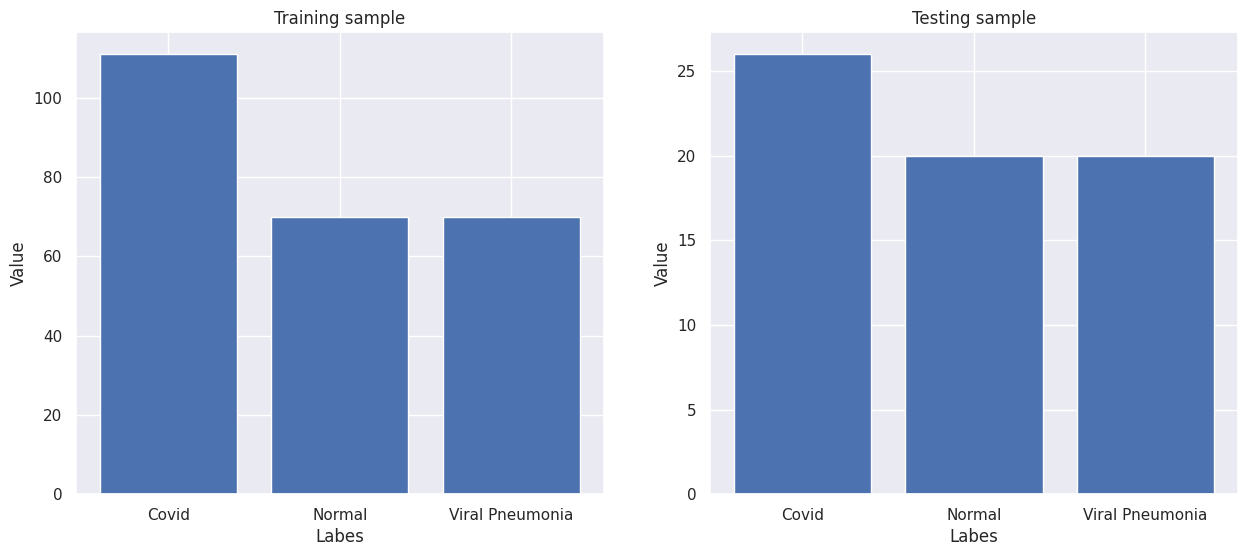

In [16]:
sns.set()
plt.figure(figsize = (15, 6))

plt.subplot(1, 2, 1)
getImgCount(trainDir, trainLabels, trainImgCount)
keys = trainImgCount.keys()
values = trainImgCount.values()
plt.bar(keys,values)
plt.xlabel('Labes')
plt.ylabel('Value')
plt.title('Training sample')
plt.savefig(figDir + f'/Training sample')


plt.subplot(1, 2, 2)
getImgCount(testDir, testLabels, testImgCount)
keys = testImgCount.keys()
values = testImgCount.values()
plt.bar(keys,values)
plt.xlabel('Labes')
plt.ylabel('Value')
plt.title('Testing sample')
plt.savefig(figDir + f'/Testing sample')


plt.show()

In [17]:
targetSize = [124, 124]
inputSize = targetSize + [1]
outputSize = len(trainLabels)
batchSize = 25
rescale = 1./ 255
epochs = 100


trainGen = ImageDataGenerator(rescale=rescale,
                              horizontal_flip = True,
                              vertical_flip = True,
                              shear_range=16,
                              validation_split =0.2)

testGen = ImageDataGenerator(rescale=rescale)


trainGenerator = trainGen.flow_from_directory(trainDir,
                                              target_size=targetSize,
                                              class_mode='categorical',
                                              color_mode = 'grayscale',
                                              batch_size = batchSize,
                                              shuffle = True,
                                              subset = 'training')

validGenerator = trainGen.flow_from_directory(trainDir,
                                              target_size=targetSize,
                                              class_mode='categorical',
                                              color_mode = 'grayscale',
                                              batch_size = batchSize,
                                              shuffle = True,
                                              subset = 'validation')

testGenerator = testGen.flow_from_directory(testDir,
                                              target_size=targetSize,
                                              class_mode='categorical',
                                              color_mode = 'grayscale',
                                              batch_size = batchSize)

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [33]:
stepsPertrainingEpoch = trainGenerator.n // trainGenerator.batch_size
stepsPerValidationEpoch = validGenerator.n // validGenerator.batch_size
stepsPerTestingEpoch = testGenerator.n // testGenerator.batch_size


print(f"Every training epoch has {stepsPertrainingEpoch} steps.")
print(f"Every training epoch has {stepsPertrainingEpoch} steps.")
print(f"Every testing epoch has {stepsPerTestingEpoch} steps.")

Every training epoch has 8 steps.
Every training epoch has 8 steps.
Every testing epoch has 2 steps.


In [27]:
classIndices = trainGenerator.class_indices

print(f"Class Indices : {classIndices}")

outClass = {v : k for k, v in classIndices.items()}

print(f"Output classes : {outClass}")

Class Indices : {'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
Output classes : {0: 'Covid', 1: 'Normal', 2: 'Viral Pneumonia'}


In [36]:
y = trainGenerator.classes

classWeight = class_weight.compute_class_weight(class_weight = 'balanced',classes= np.unique(y), y=y)

print(f"class weights : {classWeight}")

classWeights = {}

for i, j in enumerate(np.unique(y)):
  classWeights[j] = classWeight[i]

print(f"class weights for each class : {classWeights}")

class weights : [0.75280899 1.19642857 1.19642857]
class weights for each class : {0: 0.7528089887640449, 1: 1.1964285714285714, 2: 1.1964285714285714}


In [19]:
earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=2,
                              verbose=1)

reduceLr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=2,
                              min_lr=0.000001,
                              model='auto')

modelCheck = ModelCheckpoint("model_weights.h5",
                             monitor="val_accuracy",
                             save_weights_only=True,
                             mode="max",
                             verbose=1)


callBacks = [earlyStopping, reduceLr, modelCheck, PlotLossesKerasTF()]

In [20]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=inputSize))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv2D(40, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(40, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(256, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(units = 256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(units = outputSize , activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 62, 62, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 40)        1

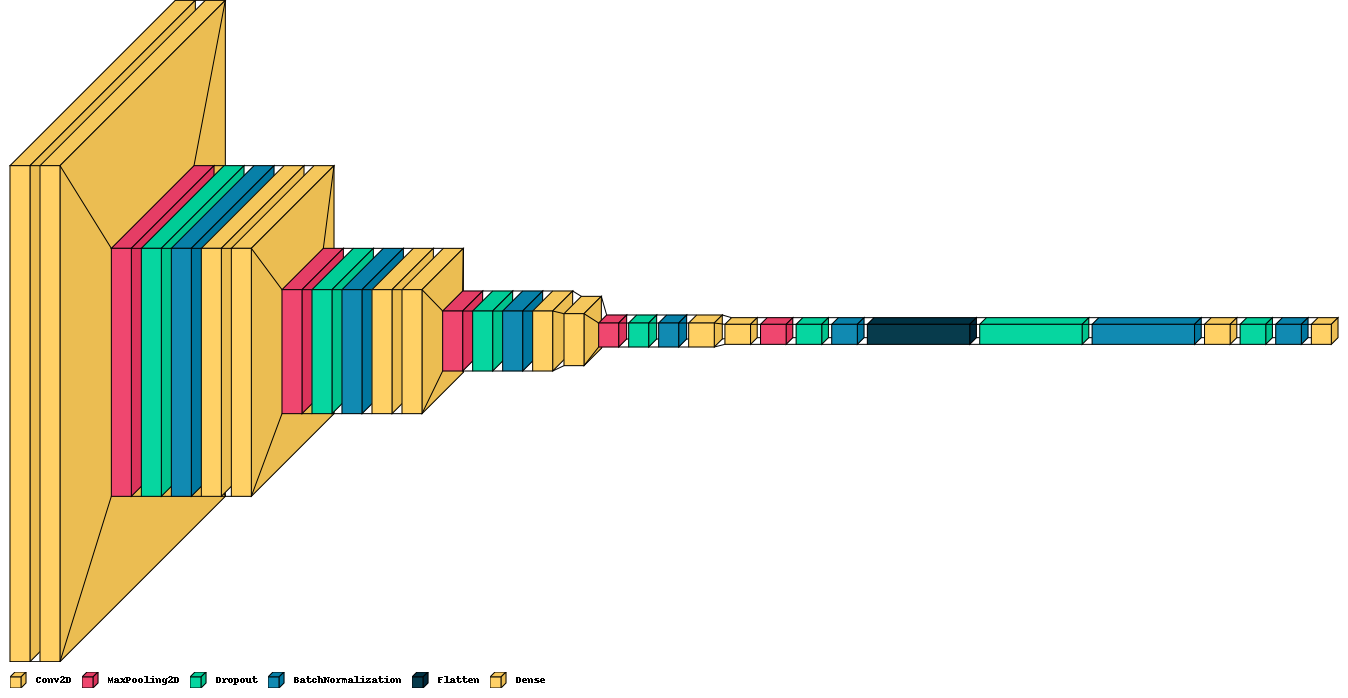

In [24]:
visualkeras.layered_view(model, legend =True)

In [25]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

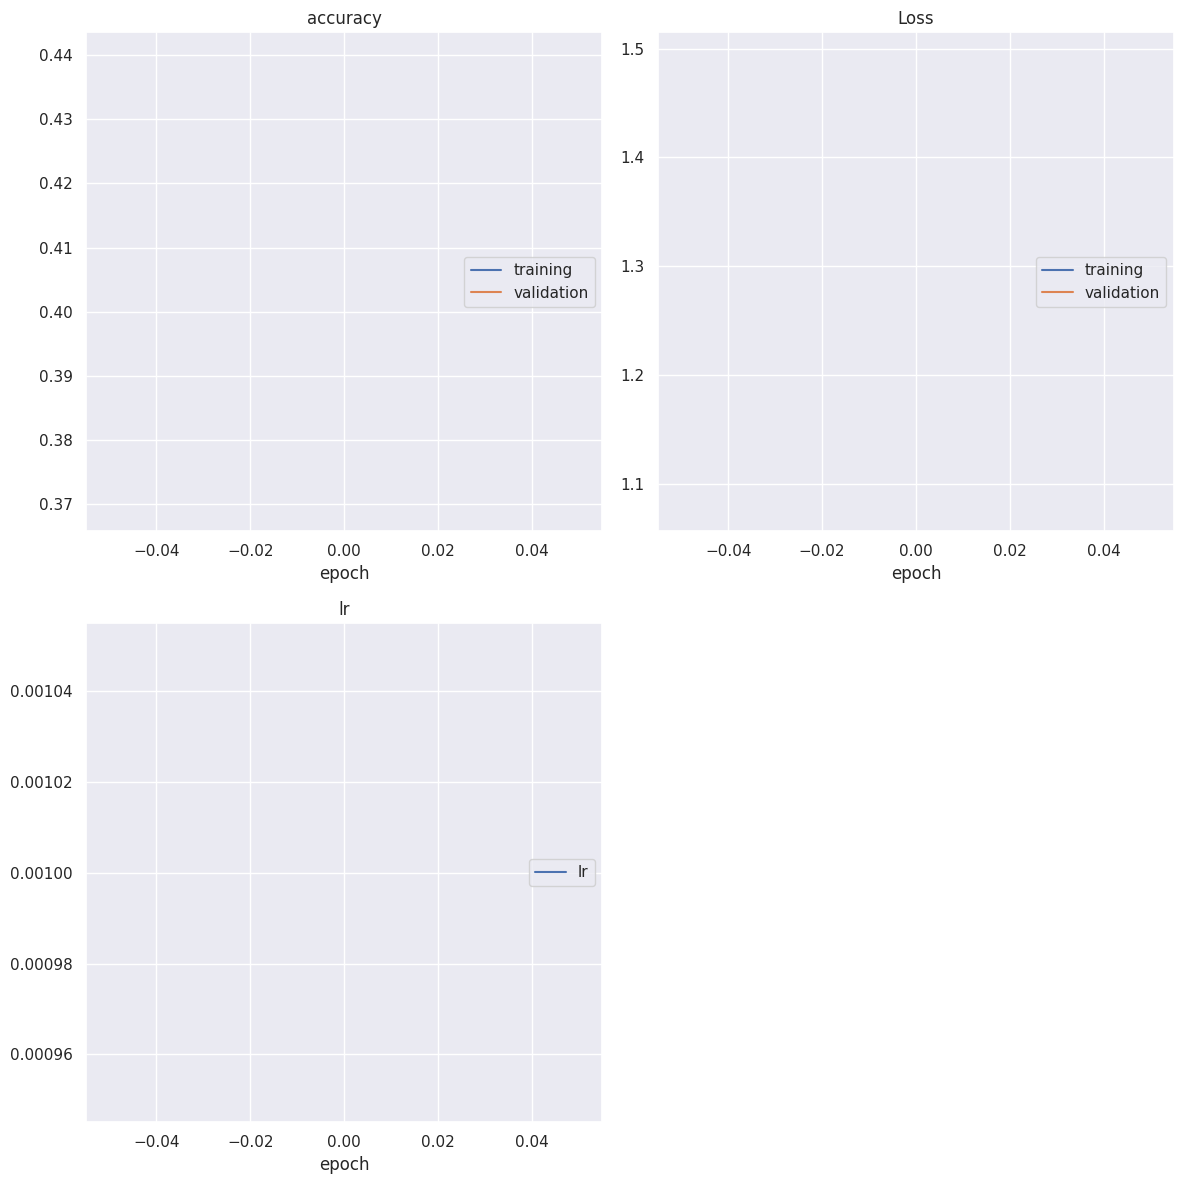

accuracy
	training         	 (min:    0.369, max:    0.369, cur:    0.369)
	validation       	 (min:    0.440, max:    0.440, cur:    0.440)
Loss
	training         	 (min:    1.494, max:    1.494, cur:    1.494)
	validation       	 (min:    1.077, max:    1.077, cur:    1.077)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
8/8 [==============================] - 28s 864ms/step - loss: 1.4941 - accuracy: 0.3693 - val_loss: 1.0772 - val_accuracy: 0.4400 - lr: 0.0010


In [ ]:
modelHist = model.fit_generator(trainGenerator,
                                steps_per_epoch=stepsPertrainingEpoch,
                                epochs = epochs,
                                verbose=1,
                                callbacks=callBacks,
                                validation_data=validGenerator,
                                validation_steps=stepsPerValidationEpoch,
                                class_weight= classWeights,
                                workers=-1,
                                use_multiprocessing=True,
                                shuffle=True)